In [1]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

\begin{equation}
    y_1, \ldots y_n \mid \tilde p \sim \int_{\Theta} f(\cdot \mid \theta) \tilde p(d\theta) = (1)
\end{equation}

$$ 
  \tilde p = \sum_{h \ge 1} w_h \delta_{\theta_h^*}
$$

Hence 
$$ 
   (1) = \sum_{h \geq 1} w_h N(\cdot | \mu_h, \sigma^2_h)
$$

see Sethuraman (1994) 

 $ w_h $ comes from a Stick-Breaking process, $\theta^*$ are i.i.d from $G_\theta$

to work with stan:fix H (H=20)

$\nu_h \sim Beta(1,\alpha) $, $h=1,....,H-1$, $\nu_H = 1$

$ w_1  = 1, \quad w_j =\nu_j \prod_{h=1}^{j-1}(1 - \nu_j) $

$ f(\cdot \mid \theta)$ is the Gaussian density, $\theta = (\mu, \sigma^2)$
$ G_\theta(\mu, \sigma^2) = N(\mu | \mu_0, s_0^2) \times IG(\sigma^2 | a,b)$

In [3]:
cumprod_one_minus_v = exp(cumulative_sum(log1m(nus)));
eta[1] = nus[1];
eta[2:(H-1)] = nus[2:(H-1)] * cumprod_one_minus_v[1:(H-2)];
eta[H] = cumprod_one_minus_v[H - 1];

NameError: name 'exp' is not defined

In [4]:
dp_mix_stan = """

data {
    int<lower=1> N;
    vector[N] y;
    
    real<lower=0> alpha;
    real mu0;
    real<lower=0> s0;
    
    real<lower=0> a;
    real<lower=0> b;
    
    int<lower=1> H;
    
    int<lower=1> ngrid;
    vector[ngrid] xgrid;
}

parameters {
    vector[H] means;
    vector<lower=0>[H] vars;
    
    vector<lower=0, upper=1>[H-1] nus;
}

transformed parameters{
    vector[H] sds= sqrt(vars);
    
    simplex[H] ws;
    
    vector<lower=0, upper=1>[H-1] cumprod_one_mv;
    cumprod_one_mv = exp(cumulative_sum(log1m(nus)));
    
    ws[1] = nus[1];
    ws[2:(H-1)] = nus[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    ws[H] = cumprod_one_mv[H-1];
}

model {
    nus ~ beta(1,alpha);
    means ~ normal(mu0, s0);
    vars ~ inv_gamma(a,b);
    
    for (i in 1:N) {
        vector[H] log_probas;
        for (h in 1:H) {
            log_probas[h] = log(ws[h]) + normal_lpdf(y[i] | means[h], sds[h]);
        }
        target += log_sum_exp(log_probas);
    }
}

generated quantities {
    vector[N] clus_allocs;
    
     for (i in 1:N) {
        vector[H] log_probas;
        for (h in 1:H) {
            log_probas[h] = log(ws[h]) + normal_lpdf(y[i] | means[h], sds[h]);
        }
        clus_allocs[i] = categorical_rng(softmax(log_probas));
    }
    vector[ngrid] dens;
    
     for (i in 1:ngrid) {
        vector[H] log_probas;
        for (h in 1:H) {
            log_probas[h] = log(ws[h]) + normal_lpdf(xgrid[i] | means[h], sds[h]);
        }
        dens[i] =  exp(log_sum_exp(log_probas));
    }
}




"""
# stan for  simulation of a dirichlet process and cluster allocation 
# vecot in which we want to evaluate the density vector[ngrid] dens

stan_file = "dpm.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
    
dpm_stan = CmdStanModel(stan_file=stan_file)

14:17:45 - cmdstanpy - INFO - compiling stan file /home/daan/bayesian-project/dpm.stan to exe file /home/daan/bayesian-project/dpm
14:17:58 - cmdstanpy - INFO - compiled model executable: /home/daan/bayesian-project/dpm


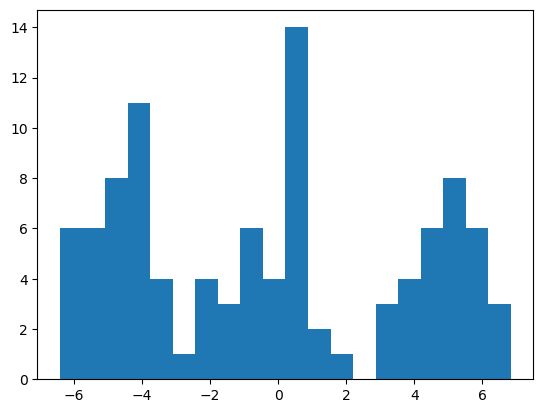

In [5]:
## generate some data

ndata = 100
means = np.array([-5, 0, 5])
true_clus = np.random.choice(np.arange(3), size=ndata)

data = np.random.normal(loc=means[true_clus])
plt.hist(data, bins=20)
plt.show()

In [8]:
xgrid = np.linspace(-10,10,500);

stan_data = {
    "N": len(data),
    "y": data,
    "H": 10,
    "alpha": 1,
    "mu0": 0.0,
    "s0": 5,
    "a": 2,
    "b": 2,
    "ngrid":len(xgrid),
    "xgrid": xgrid
    
}

In [9]:
fit = dpm_stan.sample(stan_data)

14:18:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:18:40 - cmdstanpy - INFO - CmdStan done processing.
14:18:40 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 9 divergent transitions (0.9%)
	Use function "diagnose()" to see further information.


In [10]:
dp_stan_fit = az.from_cmdstanpy(fit)
#se una catena va veloce e l'altra va lenta vuol dire che le posteriors sono kind of rubbish 

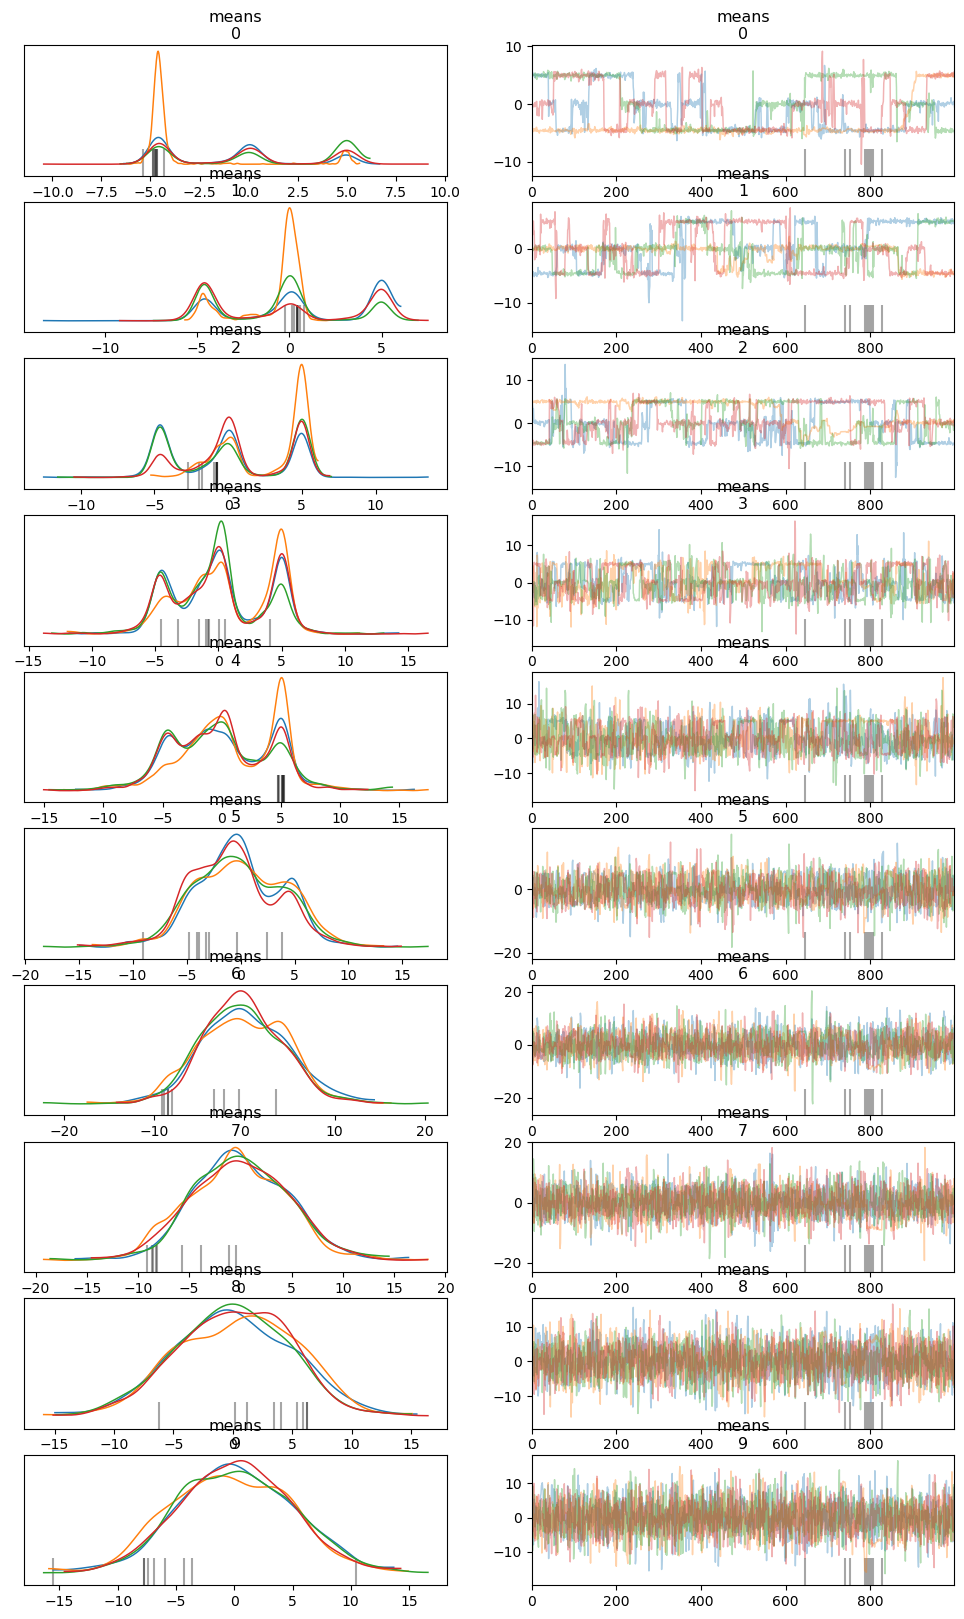

In [11]:
az.plot_trace(dp_stan_fit, var_names=["means"], compact=False)
plt.show()

In [ ]:
clus_chains = dp_stan_fit.posterior.clus_allocs.values[0, :, :]
np.mean(clus_chains, axis = 0)

#next lesson we will show this problem as a decision iteration problem 

In [ ]:
# Show the clustering
clus =  dp_stan_fit.posterior.clus_allocs.values[0, -1, :]

plt.hist(data, alpha = 0.3, density = True)


for i, cv in enumerate(np.unique(clus)):
    currd = data[clus == cv]
    plt.scatter(currd, np.zeros_like(currd) + 0.01*(i+1))


plt.plot(xgrid, np.mean(dp_stan_fit.posterior.dens.values[0,:,:],axis = 0))

plt.show()
# in stan fitting mixture models is difficult he said :(

# Implementation by hand: the marginal sampler

In [ ]:
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

state of the MCMC: cluster allocations, the $\theta^*_h$

$$
    Y_i \mid \theta_i \sim N(\cdot \mid \theta_i)
$$

$$
    \theta_1, \ldots, \theta_N \sim Gen-Polya-Urn(\alpha, G_0)
$$
equivalent to
$$
    Y_i \mid c, \theta^* \sim N(\cdot \mid \theta^*_{c_i})
$$
$$
    c_i, \ldots, c_n \sim CRP(\alpha)
$$
$$
    \theta^*_h \sim G_0
$$

$$
    \theta_i \mid \theta_{-i}, y \sim \frac{\alpha}{\alpha + n -1} m(Y_i) H(\theta_i) + \sum_{k=1}^{K^{-i}} \frac{n_k^{-i}}{\alpha + n -1} f(Y_i \mid \theta^*_k) \delta_{\theta_h^*} (\theta_i)
$$

$$
P(c_i = h | ...) \propto n_{h}^{-i} \times f(Y_i \mid \theta^*_h), \quad h =1, ...,K
$$
$$
    P(c_i = H + 1|...) \propto a \times m(Y_i)
$$

In [ ]:
# G_0 is the normal inverse gamma distribution 
mu0, lam, a, b = 0.0, 0.1, 2, 2
alpha = 1.0
data = np.sort(data)

In [ ]:
from scipy.special import softmax

def update_nnig_params(clusdata, mu0, lam, a, b):
    mupost = (mu0 * lam + np.sum(clusdata)) / (lam + len(clusdata))
    lampost = lam + len(clusdata)
    apost = a + len(clusdata) / 2
    bpost = b + \
        0.5 * np.sum((clusdata - np.mean(clusdata))**2) + \
        0.5 * lam * len(clusdata) * (mu0 - np.mean(clusdata))**2 / lampost
    
    return mupost, lampost, apost, bpost


def sample_nnig_post(clusdata, mu0, lam, a, b):
    mup, lamp, ap, bp = update_nnig_params(clusdata, mu0, lam, a, b)
    v_out = tfd.InverseGamma(ap, bp).sample()
    m_out = tfd.Normal(mup, np.sqrt(v_out / lamp)).sample()
    return m_out, v_out


def marginal_nnig(y, mu0, lam, a, b):
    sig_n = np.sqrt(b * (lam + 1) / (a * lam));
    return tfd.StudentT(2 * a, mu0, sig_n).log_prob(y)


def sample_clus_allocs(y, clus_allocs, means, vars, alpha):
    _, n_by_clus = np.unique(clus_allocs, return_counts = True)
    
    for i in range(len(y)):
        c_i = clus_allocs[i]
        n_by_clus[c_i] -= 1
        # check if it was a singleton
        if n_by_clus[c_i] == 0:
            n_by_clus = np.delete(n_by_clus, c_i)
            means = np.delete(means,c_i)
            vars = np.delete(vars,c_i)
            clus_allocs[clus_allocs > c_i] -= 1
        
        K = len(n_by_clus)
        
        log_probs = np.zeros(K+1)
        log_probs[:K] = np.log(n_by_clus)
        log_probs[:K] += tfd.Normal(means, np.sqrt(vars)).log_prob(y[i])
        log_probs[K] = np.log(alpha)
        log_probs[K] += marginal_nnig(y[i], mu0, lam,a,b)
        
        hnew = tfd.Categorical(probs = softmax(log_probs)).sample()
        
        clus_allocs[i] = hnew 
        if hnew == K:
            tmp = sample_nnig_post(np.array([y[i]]), mu0, lam,a,b)
            means = np.concatenate([means, [tmp[0]]])
            vars = np.concatenate([vars, [tmp[1]]])
            n_by_clus = np.concatenate([n_by_clus, [1]])
        else:
            n_by_clus[hnew] +=1
        
    return clus_allocs, means , vars
            
            

def sample_clus_params(y, clus_allocs, mu0, lam, a, b):
    nclus = len(np.unique(clus_allocs))
    clus_labels = np.unique(clus_allocs)
    
    means_out = np.zeros(nclus)
    vars_out = np.zeros(nclus)
    
    for h, clus_id in enumerate(clus_labels):
        tmp = sample_nnig_post(y[clus_allocs == clus_id], mu0, lam, a, b)
        means_out[h] = tmp[0]
        vars_out[h] = tmp[1]
    return means_out, vars_out

In [ ]:
def run_one_gibbs(y, clus_allocs, means, vars):
    clus_allocs, means, vars = sample_clus_allocs(
        y, clus_allocs, means, vars, alpha)
    means, vars = sample_clus_params(y, clus_allocs, mu0, lam, a, b)
    return clus_allocs, means, vars

In [ ]:
data = np.sort(data)
clus_allocs = np.random.choice(np.arange(3), size=ndata)

means = tfd.Normal(loc=0, scale=2).sample(3)
vars = np.array([1, 1, 1])

niter = 200
nburn = 100

clus_chain = []
means_chain = []
vars_chain = []

In [ ]:
%%time

for i in range(niter):
    if (i % 10) == 0:
        print("\r{0} / {1}".format(i, niter), flush=True, end=" ")
    clus_allocs, means, vars = run_one_gibbs(data, clus_allocs, means, vars)
    if i > nburn:
        clus_chain.append(clus_allocs)
        means_chain.append(means)
        vars_chain.append(vars)

In [ ]:
clus_chain[-1]

In [ ]:
means_chain[-1]

# Lets speed things up!

In [ ]:
# 1) We can pre-compute all of the log-likelihoods
# 2) We don't need to erase empty clusters

In [ ]:
tfd.Normal(means, np.sqrt(vars)).log_prob(data.reshape(-1, 1)).shape

In [ ]:
def sample_clus_allocs(y, clus_allocs, means, vars, alpha):
    _, n_by_clus = np.unique(clus_allocs, return_counts=True)
    log_liks = tfd.Normal(means, np.sqrt(vars)).log_prob(y.reshape(-1, 1))
    log_margs = marginal_nnig(y, mu0, lam, a, b)
    
    for i in range(len(y)):
        # we act like each datum is the last one entering.
        # so first we need to remove it from the state
        
        n_by_clus[clus_allocs[i]] -= 1
        H = len(n_by_clus)
        
        log_probs = np.zeros(H + 1)
        log_probs[:H] = np.log(n_by_clus + 1e-200)
        log_probs[H] = np.log(alpha)
        
        log_probs[:H] += log_liks[i, :]
        log_probs[H] += marginal_nnig(y[i], mu0, lam, a, b)
        
        hnew = tfd.Categorical(probs=softmax(log_probs)).sample()
        
        clus_allocs[i] = hnew
        if hnew == H:
            tmp = sample_nnig_post(np.array([y[i]]), mu0, lam, a, b)
            means = np.concatenate([means, [tmp[0]]])
            vars = np.concatenate([vars, [tmp[1]]])
            n_by_clus = np.concatenate([n_by_clus, [1]])
            curr_liks = np.zeros(len(y))
            curr_liks[i:] = tfd.Normal(
                tmp[0], np.sqrt(tmp[1])).log_prob(y[i])
            log_liks = np.hstack([
                log_liks, 
                curr_liks.reshape(-1, 1)])
        else:
            n_by_clus[hnew] += 1
            
    # now we eliminate empty clusters
    H = len(n_by_clus)
    for h in reversed(range(H)):
        if n_by_clus[h] == 0:
            means = np.delete(means, h)
            vars = np.delete(vars, h)
            clus_allocs[clus_allocs > h] -= 1
    
    return clus_allocs, means, vars

In [ ]:
def run_one_gibbs(y, clus_allocs, means, vars):
    clus_allocs, means, vars = sample_clus_allocs(
        y, clus_allocs, means, vars, alpha)
    means, vars = sample_clus_params(y, clus_allocs, mu0, lam, a, b)
    return clus_allocs, means, vars

In [ ]:
data = np.sort(data)
clus_allocs = np.random.choice(np.arange(3), size=ndata)

means = tfd.Normal(loc=0, scale=2).sample(3)
vars = np.array([1, 1, 1])

niter = 200
nburn = 100

clus_chain = []
means_chain = []
vars_chain = []

In [ ]:
%%time

for i in range(niter):
    if (i % 10) == 0:
        print("\r{0} / {1}".format(i, niter), flush=True, end=" ")
    clus_allocs, means, vars = run_one_gibbs(data, clus_allocs, means, vars)
    if i > nburn:
        clus_chain.append(clus_allocs)
        means_chain.append(means)
        vars_chain.append(vars)

# Bring the chavalry in

In [ ]:
from bayesmixpy import run_mcmc, build_bayesmix

In [ ]:
build_bayesmix(4)

In [ ]:
dp = """
fixed_value {
    totalmass: 1.0
}
"""

g0 = """
fixed_values {
    mean: 0.0
    var_scaling: 0.1
    shape: 2.0
    scale: 2.0
}
"""


algo = """
algo_id: "Neal2"
rng_seed: 20201124
iterations: 2000
burnin: 1000
init_num_clusters: 3
"""

In [ ]:
dens_grid = np.linspace(-10, 10, 5000)

dens, nclus_chain, clus, best_clus = run_mcmc(
    "NNIG", "DP", data, g0, dp, algo, dens_grid, out_dir="./",
    return_clusters=True, return_num_clusters=True,
    return_best_clus=True)

In [ ]:
print(dens.shape)

In [ ]:
clus = best_clus

for i, cv in enumerate(np.unique(clus)):
    currd = data[clus==cv]
    plt.scatter(currd, np.zeros_like(currd) + 0.01 * i)
    
plt.hist(data, alpha=0.1, density=True)
plt.plot(dens_grid, np.mean(np.exp(dens), axis=0))
plt.show()

In [ ]:
x, y = np.unique(nclus_chain, return_counts=True)
plt.bar(x, y)
plt.xticks(x)
plt.show()